In [ ]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from jmeterConfig import *

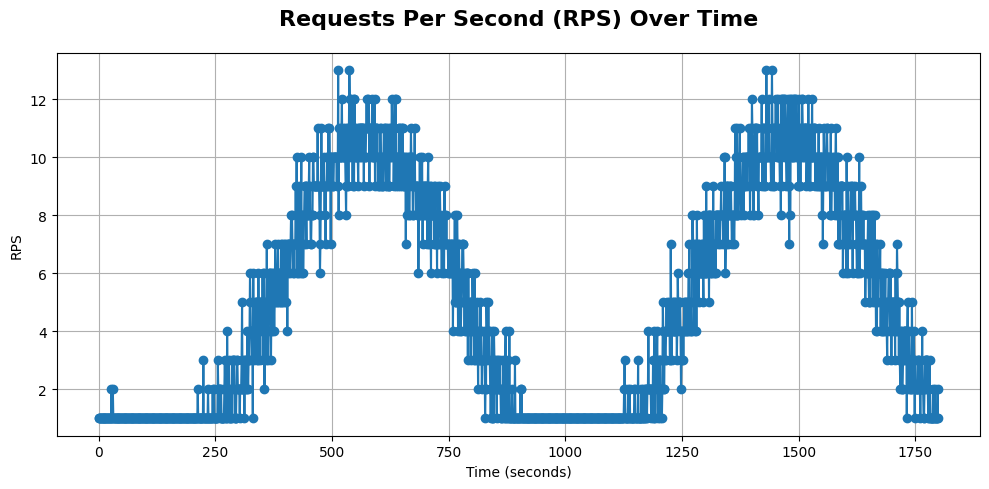

In [ ]:
# Low Workload ---> baseRPS = 2, amplitude = 3, noiseSTD = 1
# Medium Workload ---> baseRPS = 5, amplitude = 6, noiseSTD = 1
# High Workload ---> baseRPS = 7, amplitude = 9, noiseSTD = 3

seconds = 1800
baseRPS = 5
amplitude = 6
noiseSTD = 1

# Generate time vector
t = np.linspace(0, 4 * np.pi, seconds)

# Sinusoidal pattern + noise
rps = baseRPS + amplitude * np.sin(t - 15) + np.random.normal(0, noiseSTD, seconds)

# Clean it up (no negative RPS)
rps = np.clip(rps, 1, None)

df = pd.DataFrame({'Time': range(seconds), 'RPS': rps.astype(int)})
df.to_csv("MediumWorkload.csv", index = False, sep = ';')

# Just to have a visual understanding, let's plot it
plt.figure(figsize = (10, 5))
plt.plot(df['Time'], df['RPS'], marker = 'o')
plt.title('Requests Per Second (RPS) Over Time', fontsize = 16, fontweight = 'bold', pad = 20)
plt.xlabel('Time (seconds)')
plt.ylabel('RPS')
plt.grid(True)
plt.tight_layout()
plt.show()

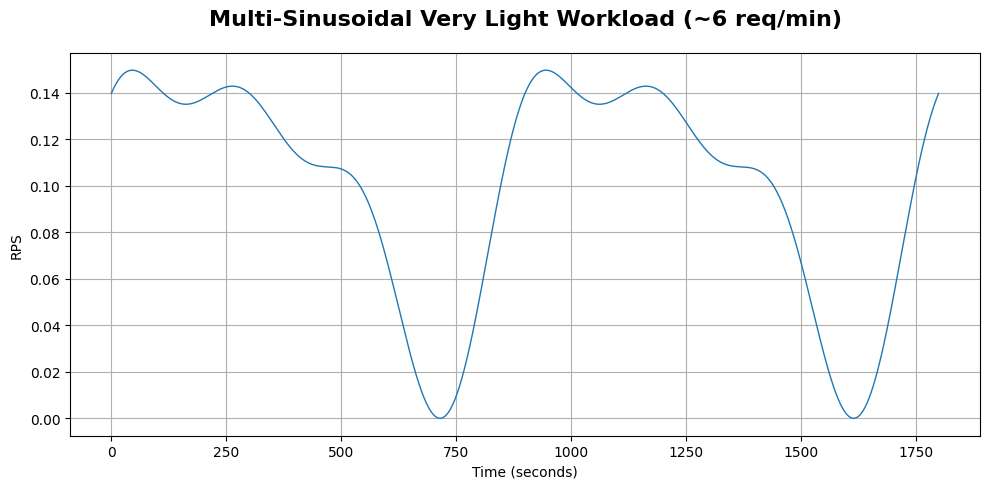

In [ ]:
# For very light workload shapes, this is more suited

seconds = 1800  
t = np.linspace(0, 4 * np.pi, seconds)

# Multiple sinusoidal components
s1 = np.sin(t)                 
s2 = 0.5 * np.sin(2 * t + 1)    
s3 = 0.3 * np.sin(3 * t + 2)   

# Combined signal
combinedSignal = s1 + s2 + s3

# Normalize to mean 0.1 RPS, shift to be non-negative
combinedSignal -= combinedSignal.min()
combinedSignal /= combinedSignal.mean()
rps = combinedSignal * 0.1 

df = pd.DataFrame({'Time': range(seconds), 'RPS': rps})
df.to_csv("VeryLightWorkload.csv", index=False, sep=';')

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df['Time'], df['RPS'], linewidth=1)
plt.title('Multi-Sinusoidal Very Light Workload (~6 req/min)', fontsize = 16, fontweight = 'bold', pad = 20)
plt.xlabel('Time (seconds)')
plt.ylabel('RPS')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# File where we have defined the specific workload behaviour
workload = 'HighWorkload.csv'
configFile = 'ConfigurationFile.jmx'

# Data of the Concurrency Thread Group
concurrencyValues = {

    "TargetLevel": "50",    
    "RampUp": "0",                          
    "Steps": "1",
    "Hold": "30"

}

# Data of the HTTP Request
httpValues = {

    "HTTPSampler.domain": "127.0.0.1",
    "HTTPSampler.port": "80",
    "HTTPSampler.path": "/multiply",
    "HTTPSampler.method": "POST"

}

jsonBody = '''{

    "matrix_a": ${matrix_a},
    "matrix_b": ${matrix_b}

}'''

# Data of the CSV file about the matrices
# We have several files:
#                               - Matrices = 50 matrices pairs of differnt size
#                               - MatricesWithSameSize1 = 3 matrices pairs 50x50
#                               - MatricesWithSameSize2 = 3 matrices pairs 100x100
#                               - MatricesWithSameSize3 = 3 matrices pairs 70x70
#                               - MatricesWithSameSize4 = 3 matrices pairs 200x200
#                               - MatricesWithSameSize5 = 3 matrices pairs 350x350

csvValues = {

    "delimiter": ";",
    "fileEncoding": "US-ASCII",
    "filename": "/Users/fabioschiliro/Desktop/Multidisciplinary Project/MultidisciplinaryProject/JMeter/MatricesWithSameSize5.csv",
    "variableNames": "matrix_a,matrix_b",
    "shareMode": "shareMode.all"

}

csvBools = {
    "ignoreFirstLine": "true",
    "quotedData": "false",
    "recycle": "true",
    "stopThread": "false"
}


# Let's create the configuration file now!
baseFile = '[Structure] Matrix Multiplication Requests.jmx'

tree = ET.parse(baseFile)
root = tree.getroot()

root = writeConcurrencyThread(root, concurrencyValues)
root = writeHTTPRequest(root, httpValues, jsonBody)
root = writeCSVFile(root, csvValues, csvBools)
root = writeWorkload(root, workload, configFile)

tree.write(configFile, encoding = 'utf-8', xml_declaration = True)
print('File correctly saved!')

File correctly saved!


In [ ]:
# Test a request to the app
df = pd.read_csv('MatricesWithSameSize5.csv', sep=';')

# Convert the string representations into actual Python lists
matrix_a = eval(df.loc[0, 'matrix_a'])
matrix_b = eval(df.loc[0, 'matrix_b'])

url = 'http://127.0.0.1/multiply'

# Prepare the POST request with JSON payload
payload = {'matrix_a': matrix_a, 'matrix_b': matrix_b}
session = requests.Session()
req = requests.Request('POST', url, json = payload)
prepped = session.prepare_request(req)

# Display the prepared request details
print("=== Prepared Request ===")
print("Method:", prepped.method)
print("URL:", prepped.url)
print("Headers:", prepped.headers)
print("Body:", prepped.body, "\n")

# Send the request and print the response (or error if the local server is unreachable)
try:

    response = requests.post(url, json = {'matrix_a': matrix_a, 'matrix_b': matrix_b})
    print("=== Response ===")
    print("Status Code:", response.status_code)
    print("Body:", response.text)
    print("---------------------------")
    print(response.json()['Service Time'])

except Exception as e:
    print("Error sending request:", e)

=== Prepared Request ===
Method: POST
URL: http://127.0.0.1/multiply
Headers: {'User-Agent': 'python-requests/2.31.0', 'Accept-Encoding': 'gzip, deflate', 'Accept': '*/*', 'Connection': 'keep-alive', 'Content-Length': '956827', 'Content-Type': 'application/json'}
Body: b'{"matrix_a": [[32, 81, 28, 61, 72, 31, 30, 32, 97, 80, 75, 44, 46, 79, 3, 32, 89, 76, 68, 51, 41, 59, 83, 59, 70, 64, 16, 34, 76, 84, 16, 37, 60, 79, 2, 61, 6, 8, 28, 96, 51, 34, 56, 88, 36, 81, 72, 83, 22, 69, 35, 95, 44, 63, 34, 87, 22, 70, 53, 7, 98, 3, 48, 96, 86, 58, 18, 6, 82, 72, 79, 80, 35, 1, 77, 91, 64, 53, 23, 93, 46, 68, 36, 53, 33, 23, 56, 52, 76, 16, 72, 47, 75, 7, 59, 9, 82, 95, 55, 60, 29, 25, 82, 42, 28, 49, 28, 79, 67, 14, 27, 24, 36, 89, 82, 54, 96, 27, 35, 70, 99, 33, 50, 80, 64, 74, 37, 32, 47, 96, 77, 55, 94, 8, 50, 49, 73, 19, 84, 57, 53, 88, 40, 10, 95, 93, 58, 46, 9, 35, 40, 7, 2, 37, 51, 5, 31, 71, 42, 61, 32, 63, 17, 70, 51, 95, 71, 52, 93, 47, 25, 34, 67, 16, 31, 59, 74, 72, 99, 78, 66, 72, 